In [1]:
import numpy as np
import pandas as pd

In [14]:
path = 'M:/My Documents/Business/Property/Statements/processed/'

def strip(df):
    df['Memo']=df['Memo'].str.strip()
    df['Subcategory']=df['Subcategory'].str.strip()
    if 'Description' in df.columns:
        df['Description']=df['Description'].str.strip()
    return df

def load(spreadsheets):
    dfIv = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    dfMt = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    df40 = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo'])
    dfRs = pd.DataFrame()
    for spreadsheet in spreadsheets:
        dfMtTemp=load_worksheet(spreadsheet, 'MT')
        dfMt=pd.concat([dfMt,dfMtTemp]) 
        dfIvTemp=load_worksheet(spreadsheet, 'IV')
        dfIv=pd.concat([dfIv,dfIvTemp])
        df40Temp=load_worksheet(spreadsheet, 'IV (4040)')
        df40=pd.concat([df40,df40Temp])
        dfRsTemp=load_rent_statement(spreadsheet)
        dfRs=pd.concat([dfRs,dfRsTemp]) 
    dfMt=strip(dfMt)
    dfIv=strip(dfIv)
    df40=strip(df40)
    
    dfMt=dfMt.loc[:, ~dfMt.columns.str.contains('^Unnamed')]
    dfIv=dfIv.loc[:, ~dfIv.columns.str.contains('^Unnamed')]
    df40=df40.loc[:, ~df40.columns.str.contains('^Unnamed')]
    
    dfMt=dfMt.set_index('Date')
    dfIv=dfIv.set_index('Date')
    df40=df40.set_index('Date')
    return dfMt, dfIv, df40, dfRs

def load_worksheet(spreadsheet, worksheet):
    input_file = path + spreadsheet + '.xlsm'
    df = pd.read_excel(input_file,sheet_name=worksheet)
    df.drop('Import', axis=1, inplace=True)
    df.drop('Number', axis=1, inplace=True)
    df = df.astype({"Description": str})
    df = df[~df.Account.isnull()]
    return df

def load_rent_statement(spreadsheet):
    worksheet='Rent Statement'
    input_file = path + spreadsheet + '.xlsm'
    dfSmtDate = pd.read_excel(input_file,sheet_name=worksheet)
    dfSmtDate=dfSmtDate.loc[dfSmtDate['Rental Statement']=='Statement Date:','Unnamed: 1'].iloc[0]

    df = pd.read_excel(input_file,sheet_name=worksheet,header=6)
    df=df.loc[(df['Owner'].notnull())&(df['Owner']!='Alhambra Road Management Ltd')]
    df=df.loc[(df['Property'].notnull())]
    df=df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    df['StatementDate'] = dfSmtDate
    df.drop('Reconciled', axis=1, inplace=True)
    df.drop('Lender', axis=1, inplace=True)
    df.drop('Account No', axis=1, inplace=True)
    df.drop('Property Id', axis=1, inplace=True)
    df.drop('Profit', axis=1, inplace=True)
    df.drop('Net Income', axis=1, inplace=True)
    
    df['Profit']=df['Rental Amount']-df['Mgmt Fees']-df['VAT']-df['Bills Paid']-df['Other Bills']
    df['Net Income']=df['Profit']-df['Mortgage Payment']
    
    df.update(df.select_dtypes(include=[np.number]).fillna(0))
    return df

def categorise(df):
    # Categorise expenses
    # Mortgage, PropertyExpense, OurRent, BealsRent, ServiceCharge
    # SchoolFees, Car, Hilltop, PersonalExpenses, RegularPayment
    global dfUncat
    df["Cat"] = np.nan
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('JASPER|TOPAZ|SIBERITE|MORTGAGE EXPRESS|NRAM|PLATFORM|AMBER|BHAM|CAPITAL|CHL|MORTGAGE TRUST')==True),"Cat"] = 'Mortgage'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*M TUCKER.*STO.*')==True) & (df.Amount > -200) & (df.Amount <-190),"Cat"] = 'Mortgage' # Kingston Rd mortgage
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Description.str.match('Rent for period')==True),"Cat"] = 'OurRent'
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Property.notnull()) & (df.Description.str.match('Rent for period')==False),"Cat"] = 'PropertyExpense'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS.*BGC')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('23 HAMPSHIRE.*STO|4-6 ALHAMBRA RD CS|12-14 ALHAMBRA RD|16-18 ALHAMBRA RD|ALHAMBRA ROAD MANA')==True),"Cat"] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*HARPUR TRUST.*|.*BEDFORD SCHOOL.*')==True),"Cat"] = 'SchoolFee'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*F VALENTINO.*')==True),"Cat"] = 'Hilltop'
    
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('HMRC')==True),"Cat"] = 'HMRC'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('CCTV|Letterbox',case=False)==True),"Cat"] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT'),"Cat"] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CASH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CRE'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='OTH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='BCC'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REFUND'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CHQ'),'Cat'] = 'PersonalExpense'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*INTERCO.*',case=False)==True),'Cat'] = 'ServiceCharge'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Description.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*13438023.*|.*83672832.*|.*23534332.*|.*13686035.*')==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*63796884.*|.*33631583.*',case=False)==True),'Cat'] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*LAND ROVER.*')==True),"Cat"] = 'Car'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='DIRECTDEBIT'),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('NATIONWIDE|KINGSTON UNITY')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REPEATPMT')&(df.Memo.str.match('.*M TUCKER.*STO.*')==True)&(df.Amount>-100),'Cat'] = 'RegularPayment'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('Sofia|Rocco', case=False)==True),'Cat'] = 'Kids'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*30728691.*')==True),'Cat'] = 'Funds3072'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*40406538 .*')==True),'Cat'] = 'Funds4040'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*60458872.*')==True),'Cat'] = 'Funds6045'

    df.loc[(df.Cat.isnull())&(df.Amount>0),'Cat'] = 'OtherIncome'
    df.loc[(df.Cat.isnull())&(df.Amount<0),'Cat'] = 'OtherExpense'

    return df

def sumOf(df,cat):
    g=pd.Grouper(freq="M")
    return df.loc[df.Cat == cat,'Amount'].groupby(g).sum()

def get_rent_statement_summary(dfRs):
    #dfSum = pd.DataFrame()
    dfSum=dfRs.groupby(['StatementDate']).sum()
    return dfSum

def get_pty_summary(dfMt,dfIv):
    dfPty = pd.DataFrame()
    dfPty['Mortgage']=pd.concat([sumOf(dfMt,'Mortgage'),sumOf(dfIv,'Mortgage')],axis=1).sum(axis=1)
    dfPty['PropertyExpense']=pd.concat([sumOf(dfMt,'PropertyExpense'),sumOf(dfIv,'PropertyExpense')],axis=1).sum(axis=1)
    dfPty['ServiceCharge']=pd.concat([sumOf(dfMt,'ServiceCharge'),sumOf(dfIv,'ServiceCharge')],axis=1).sum(axis=1)
    dfPty['OurRent']=pd.concat([sumOf(dfMt,'OurRent'),sumOf(dfIv,'OurRent')],axis=1).sum(axis=1)
    dfPty['BealsRent']=pd.concat([sumOf(dfMt,'BealsRent'),sumOf(dfIv,'BealsRent')],axis=1).sum(axis=1)
    
    dfPty = dfPty.fillna(0)
    
    dfPty['TotalRent']=dfPty['OurRent'] + dfPty['BealsRent']
    dfPty['NetProfit']=dfPty['OurRent'] + dfPty['BealsRent'] + dfPty['Mortgage'] + dfPty['PropertyExpense'] + dfPty['ServiceCharge']
    return dfPty

def get_outgoings(dfPty,dfMt,dfIv,df40):
    dfOut = pd.DataFrame()
    dfOut['NetProfit']=dfPty['NetProfit']
    dfOut['SchoolFee']=pd.concat([sumOf(dfMt,'SchoolFee'),sumOf(dfIv,'SchoolFee'),sumOf(df40,'SchoolFee')],axis=1).sum(axis=1)
    dfOut['Hilltop']=pd.concat([sumOf(dfMt,'Hilltop'),sumOf(dfIv,'Hilltop'),sumOf(df40,'Hilltop')],axis=1).sum(axis=1)
    dfOut['Car']=pd.concat([sumOf(dfMt,'Car'),sumOf(dfIv,'Car'),sumOf(df40,'Car')],axis=1).sum(axis=1)
    dfOut['RegularPayment']=pd.concat([sumOf(dfMt,'RegularPayment'),sumOf(dfIv,'RegularPayment'),sumOf(df40,'RegularPayment')],axis=1).sum(axis=1)
    dfOut['PersonalExpense']=pd.concat([sumOf(dfMt,'PersonalExpense'),sumOf(dfIv,'PersonalExpense'),sumOf(df40,'PersonalExpense')],axis=1).sum(axis=1)
    dfOut['HMRC']=pd.concat([sumOf(dfMt,'HMRC'),sumOf(dfIv,'HMRC'),sumOf(df40,'HMRC')],axis=1).sum(axis=1) + \
                   pd.concat([sumOf(dfMt,'HMRC'),sumOf(dfIv,'HMRC'),sumOf(df40,'HMRC')],axis=1).sum(axis=1)    
    dfOut['Other']=pd.concat([sumOf(dfMt,'OtherIncome'),sumOf(dfIv,'OtherIncome'),sumOf(df40,'OtherIncome')],axis=1).sum(axis=1) + \
                   pd.concat([sumOf(dfMt,'OtherExpense'),sumOf(dfIv,'OtherExpense'),sumOf(df40,'OtherExpense')],axis=1).sum(axis=1)    
    dfOut = dfOut.fillna(0)
    dfOut['TotalOutgoings']=dfOut['SchoolFee'] + dfOut['Car'] + dfOut['Hilltop'] + dfOut['PersonalExpense'] + dfOut['RegularPayment']
    dfOut['Profit']=dfPty['NetProfit']+dfOut['TotalOutgoings']
    dfOut['Other']=dfOut['Other'].fillna(0)
    return dfOut
    
# add subcats for pie chart - food, home, fast food etc

In [15]:
spreadsheets=[ \
              'Beals_RentalStatement_JUN2018_11072018_1961', 'Beals_RentalStatement_JUL2018_21082018_1964', \
              'Beals_RentalStatement_AUG2018_15092018_1968', 'Beals_RentalStatement_SEP2018_20102018_1971', \
              'Beals_RentalStatement_OCT2018_16112018_1978', 'Beals_RentalStatement_NOV2018_22122018_1979', \
              'Beals_RentalStatement_DEC2018_18012019_1986', 'Beals_RentalStatement_JAN2019_23022019_1988', \
              'Beals_RentalStatement_FEB2019_19042019_1991', 'Beals_RentalStatement_MAR2019_19042019_1995', \
              'Beals_RentalStatement_APR2019_30062019_2036', 'Beals_RentalStatement_MAY2019_30062019_2039', \
              
              'Beals_RentalStatement_JUN2019_08082019_2041', 'Beals_RentalStatement_JUL2019_12102019_2048', \
              'Beals_RentalStatement_AUG2019_12102019_2049', 'Beals_RentalStatement_SEP2019_01122019_2054', \
              'Beals_RentalStatement_OCT2019_05042020_2058', 'Beals_RentalStatement_NOV2019_05042020_2059', \
              'Beals_RentalStatement_DEC2019_05042020_2061', 'Beals_RentalStatement_JAN2020_05042020_2063', \
              'Beals_RentalStatement_FEB2020_05042020_2065', 'Beals_RentalStatement_MAR2020_20082020_2066', \
              'Beals_RentalStatement_APR2020_21082020_2071', 'Beals_RentalStatement_MAY2020_28082020_2082', \
              'Beals_RentalStatement_JUN2020_28082020_2083', 'Beals_RentalStatement_JUL2020_28082020_2084', \
              'Beals_RentalStatement_AUG2020_23062021_2098', 'Beals_RentalStatement_SEP2020_23062021_2105', \
              'Beals_RentalStatement_OCT2020_23062021_2109', 'Beals_RentalStatement_NOV2020_23062021_2124', \
              'Beals_RentalStatement_DEC2020_23062021_2125']

dfMt, dfIv, df40, dfRs = load(spreadsheets)
dfIv=categorise(dfIv)
dfMt=categorise(dfMt)
df40=categorise(df40)

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
dfSum = get_rent_statement_summary(dfRs)
dfSum

,Rental Amount,Mgmt Fees,VAT,Bills Paid,Paid,Other Bills,Profit,Mortgage Payment,Net Income
StatementDate,,,,,,,,,
2018-06-30,18743.59,1124.62,224.93,593.20,16552.31,0.00,16800.84,8882.45,7918.39
2018-07-31,25977.29,1558.61,311.69,1146.80,23142.99,0.00,22960.19,8663.57,14296.62
2018-08-31,20163.55,1209.84,241.96,2251.00,16425.75,581.33,15879.42,8663.57,7215.85
2018-09-30,30099.26,1769.95,354.00,1397.00,26523.31,3652.30,22926.01,9204.04,13721.97
2018-10-31,18447.61,1106.82,221.40,163.75,16955.64,2863.73,14091.91,9894.10,4197.81
2018-11-30,19508.32,1170.47,234.12,2758.34,15801.39,2057.30,13288.09,9753.06,3535.03
2018-12-31,17613.01,1056.72,211.36,1125.21,15219.72,4529.60,10774.05,9782.47,991.58
2019-01-31,18578.89,1114.72,222.96,1003.32,15681.09,3145.27,0.00,9392.45,0.00
2019-02-28,18577.91,1114.72,222.94,540.00,16712.25,1671.60,0.00,9391.19,0.00


In [18]:
dfRs.loc[dfRs.StatementDate=='2019-01-31'].groupby(['StatementDate']).sum()

,Rental Amount,Mgmt Fees,VAT,Bills Paid,Paid,Other Bills,Mortgage Payment,Profit,Net Income
StatementDate,,,,,,,,,
2019-01-31,18578.89,1114.72,222.96,1003.32,15681.09,3145.27,9392.45,0.0,0.0


In [5]:
dfPty=get_pty_summary(dfMt,dfIv)
dfPty

,Mortgage,PropertyExpense,ServiceCharge,OurRent,BealsRent,TotalRent,NetProfit
Date,,,,,,,
2018-06-30,-8973.85,0.00,-1200.00,0.00,17097.80,17097.80,6923.95
2018-07-31,-8973.85,0.00,-1200.00,0.00,15967.15,15967.15,5793.30
2018-08-31,-8973.85,-581.33,-2200.00,0.00,23196.75,23196.75,11441.57
2018-09-30,-9515.52,-3652.30,-1200.00,0.00,26533.75,26533.75,12165.93
2018-10-31,-9989.03,-2863.73,-1200.00,0.00,16411.48,16411.48,2358.72
2018-11-30,-9847.99,-2057.30,-1200.00,0.00,16148.39,16148.39,3043.10
2018-12-31,-9877.40,-4529.60,-2647.88,0.00,15707.92,15707.92,-1346.96
2019-01-31,-9877.40,-3145.27,-1200.00,0.00,15270.63,15270.63,1047.96
2019-02-28,-9876.14,-1671.60,-1200.00,0.00,16229.35,16229.35,3481.61


In [6]:
dfOut=get_outgoings(dfPty,dfMt,dfIv,df40)
dfOut

,NetProfit,SchoolFee,Hilltop,Car,RegularPayment,PersonalExpense,HMRC,Other,TotalOutgoings,Profit
Date,,,,,,,,,,
2018-06-30,6923.95,-3736.38,-102.0,-476.44,-575.64,-7293.55,0.00,0.00,-12184.01,-5260.06
2018-07-31,5793.30,-3736.38,-122.0,-476.44,-813.46,-5275.58,-4235.24,2117.62,-10423.86,-4630.56
2018-08-31,11441.57,0.00,-102.0,-476.44,-584.93,-5717.20,0.00,-3932.64,-6880.57,4561.00
2018-09-30,12165.93,-4570.43,-102.0,-476.44,-516.71,-7122.01,0.00,3246.22,-12787.59,-621.66
2018-10-31,2358.72,-4570.46,-102.0,-476.44,-712.63,-6084.58,0.00,-290.00,-11946.11,-9587.39
2018-11-30,3043.10,-4570.46,-102.0,-476.44,-739.33,-4356.04,0.00,4956.50,-10244.27,-7201.17
2018-12-31,-1346.96,0.00,-132.0,-476.44,-634.46,-6045.43,0.00,6593.85,-7288.33,-8635.29
2019-01-31,1047.96,-4515.01,-102.0,-476.44,-602.34,-4339.22,0.00,4847.83,-10035.01,-8987.05
2019-02-28,3481.61,-4495.05,-102.0,-476.44,-525.23,-3027.80,0.00,19058.56,-8626.52,-5144.91


In [7]:
dfMt.loc[(dfMt.Cat=='OtherIncome')]
#dfIv.loc[(dfIv.Cat=='OtherIncome')]

,Account,Amount,Description,Memo,Property,Subcategory,Cat
Date,,,,,,,
2018-08-01,20-74-09 60458872,506.85,Platform payments,20MILTON KEYNES REM,NaN,REM,OtherIncome
2018-08-21,20-74-09 60458872,364.03,Platform payments,41FLITWICK REM,NaN,REM,OtherIncome
2018-12-24,20-74-09 60458872,24.29,nan,209254 13676978 EOY FT,NaN,FT,OtherIncome
2019-01-09,20-74-09 60458872,1043.83,Hampshire Terrace Insurance,209254 13676978 INSURANCE FT,NaN,FT,OtherIncome
2019-02-26,20-74-09 60458872,19274.56,nan,BPL SOLICITORS LIM BALANCE TO CLIENT BGC,NaN,DIRECTDEP,OtherIncome
2019-03-04,20-74-09 60458872,8000.00,nan,M Tucker M TUCKER BGC,NaN,DIRECTDEP,OtherIncome
2019-03-04,20-74-09 60458872,0.01,nan,PAYPAL CODE 5956 PAYPAL CODE 5956 BGC,NaN,DIRECTDEP,OtherIncome
2019-03-04,20-74-09 60458872,10000.00,nan,M Tucker M TUCKER BGC,NaN,DIRECTDEP,OtherIncome
2019-03-04,20-74-09 60458872,10000.00,nan,M Tucker M TUCKER BGC,NaN,DIRECTDEP,OtherIncome


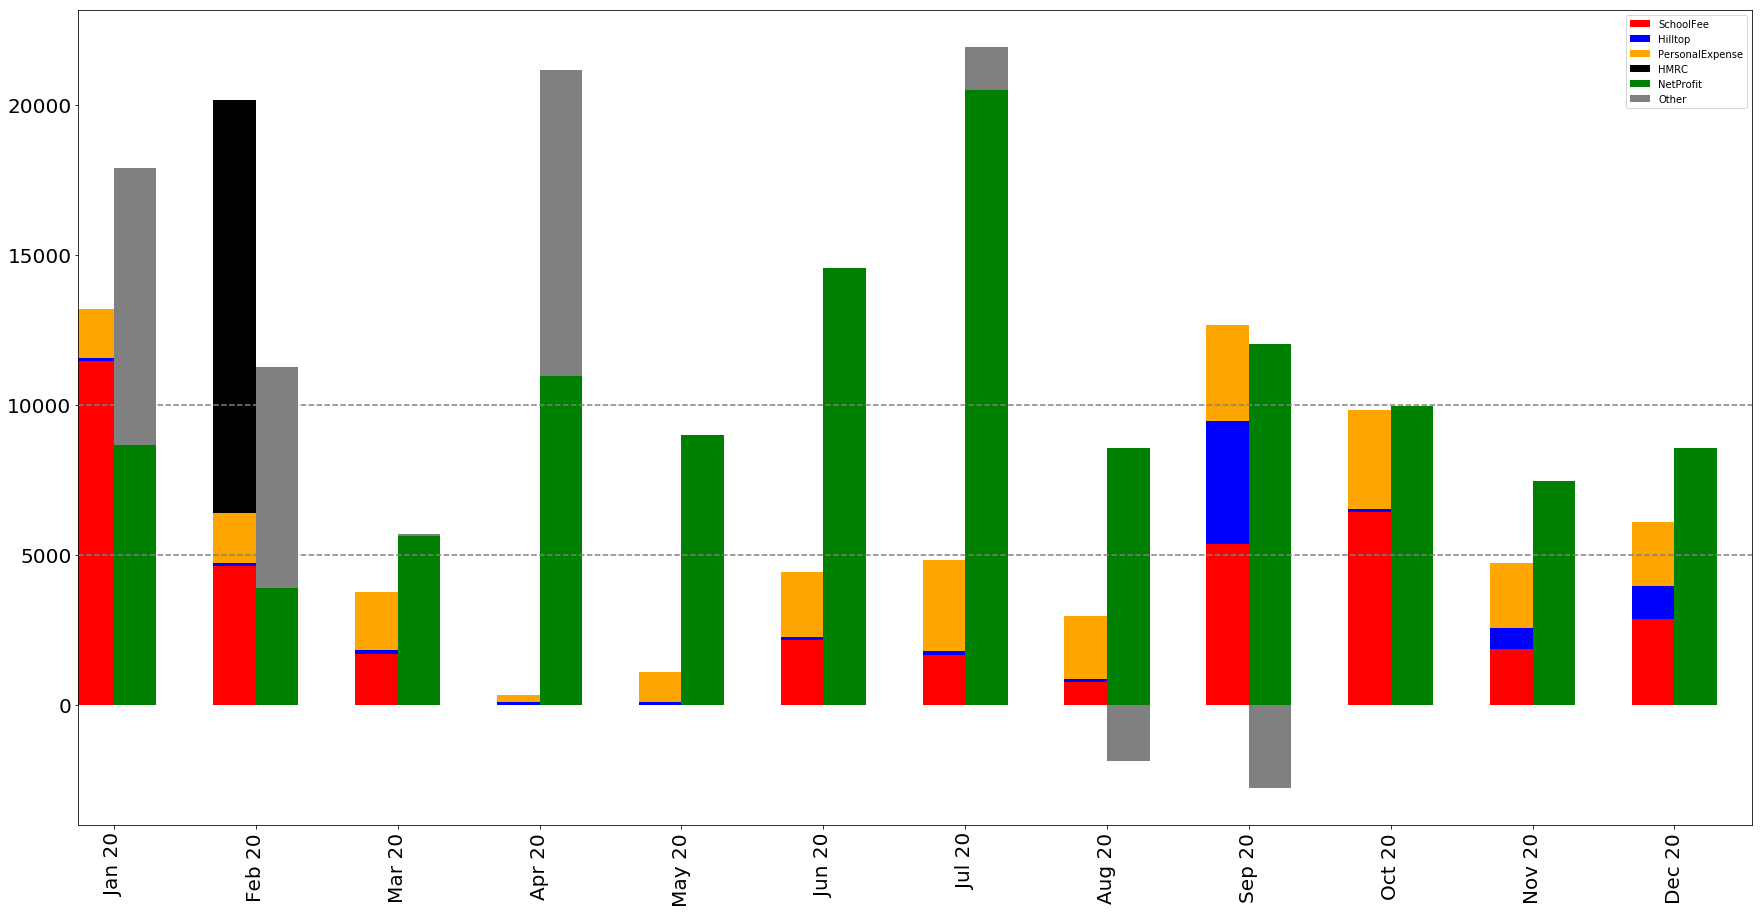

In [31]:
from matplotlib.pyplot import figure

dfBar=pd.DataFrame()
range_start='2020-01-01'
range_end='2020-12-31'
dfBar['NetProfit'] = dfOut.loc[range_start:range_end]['NetProfit']
dfBar['PersonalExpense'] = abs(dfOut.loc[range_start:range_end]['PersonalExpense']) + dfOut.loc[range_start:range_end]['RegularPayment']
dfBar['Hilltop'] = abs(dfOut.loc[range_start:range_end]['Hilltop'])
dfBar['SchoolFee'] = abs(dfOut.loc[range_start:range_end]['SchoolFee'])
dfBar['HMRC'] = abs(dfOut.loc[range_start:range_end]['HMRC'])
dfBar['Other'] = dfOut.loc[range_start:range_end]['Other']
dfBar.index = dfBar.index.strftime('%b %y')

ax = dfBar[['SchoolFee','Hilltop','PersonalExpense','HMRC']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange','black'])
ax.axhline(5000, color="gray",linestyle='--')
ax.axhline(10000, color="gray",linestyle='--')
dfBar[['NetProfit','Other']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','grey'],figsize=(30,15),fontsize=20)


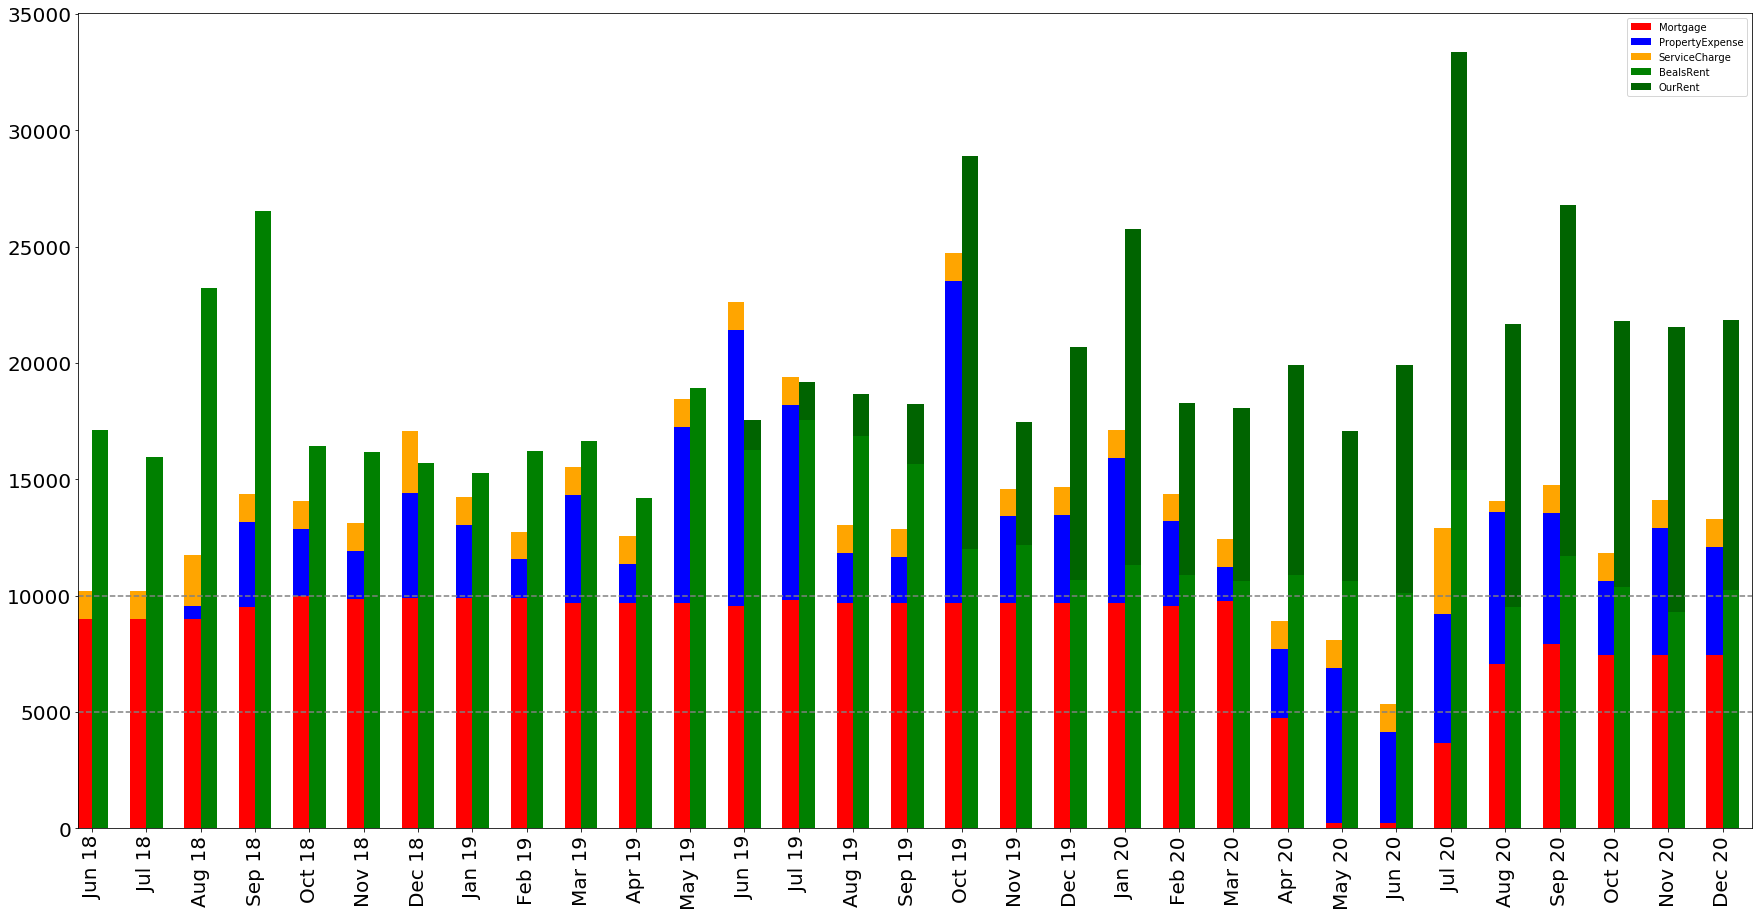

In [35]:
from matplotlib.pyplot import figure

dfBar=pd.DataFrame()
range_start='2018-01-01'
range_end='2020-12-31'
dfBar['OurRent'] = dfPty.loc[range_start:range_end]['OurRent']
dfBar['BealsRent'] = dfPty.loc[range_start:range_end]['BealsRent']
dfBar['Mortgage'] = abs(dfPty.loc[range_start:range_end]['Mortgage'])
dfBar['PropertyExpense'] = abs(dfPty.loc[range_start:range_end]['PropertyExpense'])
dfBar['ServiceCharge'] = abs(dfPty.loc[range_start:range_end]['ServiceCharge'])
dfBar.index = dfBar.index.strftime('%b %y')

ax = dfBar[['Mortgage','PropertyExpense','ServiceCharge']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange'])
ax.axhline(5000, color="gray",linestyle='--')
ax.axhline(10000, color="gray",linestyle='--')
dfBar[['BealsRent','OurRent']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','darkgreen'],figsize=(30,15),fontsize=20)


In [25]:
dfPty.loc['2020-01-01':'2020-12-31']['TotalRent'].groupby(pd.Grouper(freq="M")).sum().mean()

22163.838333333333

In [26]:
dfPty.loc['2019-01-01':'2019-12-31']['TotalRent'].groupby(pd.Grouper(freq="M")).sum().mean()

18490.675

In [27]:
dfPty.loc['2018-01-01':'2018-12-31']['TotalRent'].groupby(pd.Grouper(freq="M")).sum().mean()

18723.320000000003

In [15]:
dfOut.loc['2020-01-01':'2020-12-31']['SchoolFee'].sum()

-38884.49

In [10]:
dfMt.to_csv('dfMt.csv')  

In [39]:
worksheet='Rent Statement'
input_file = path + 'Beals_RentalStatement_DEC2020_23062021_2125' + '.xlsm'
dfSmtDate = pd.read_excel(input_file,sheet_name=worksheet)
dfSmtDate=dfSmtDate.loc[dfSmtDate['Rental Statement']=='Statement Date:','Unnamed: 1'].iloc[0]

df = pd.read_excel(input_file,sheet_name=worksheet,header=6)
df=df.loc[(df['Owner'].notnull())&(df['Owner']!='Alhambra Road Management Ltd')]
df=df.loc[(df['Property'].notnull())]
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

df['StatementDate'] = dfSmtDate
df.drop('Reconciled', axis=1, inplace=True)
df.drop('Lender', axis=1, inplace=True)
df.drop('Account No', axis=1, inplace=True)
df.drop('Property Id', axis=1, inplace=True)
df.update(df.select_dtypes(include=[np.number]).fillna(0))
df.tail(10)


,Property,Tenancy,Agent,Rent Period from,Rent Period to,Rental Amount,Mgmt Fees,VAT,Bills Paid,Paid,Date Paid,Other Bills,Profit,Status,Mortgage Payment,Net Income,Other information,Owner,StatementDate
44,Flat 14 - 12-14 Alhambra Rd,Paul McIlwraith (06/08/2020 - present),Beals,2020-12-06,2021-01-05 00:00:00,500.00,35.00,7.00,6.0,452.00,2020-12-07 14:38:00,0.00,452.00,Paid,194.02,257.98,NaN,Mathew Tucker,2020-12-31
45,Flat 16 - 12-14 Alhambra Rd,Mr Milligan (19/03/2015 - present),Baker and Elder,2020-11-19,2021-01-18 00:00:00,461.52,27.69,5.54,6.0,422.29,2020-12-15 14:04:00,0.00,422.29,Paid,159.08,263.21,NaN,Ivana Valentino,2020-12-31
47,Flat 1 - 16-18 Alhambra Rd,Bianca Vintila (30/10/2019 - present),None,2020-12-30,2021-01-29 00:00:00,675.00,0.00,0.00,0.0,675.00,2020-12-29 00:00:00,0.00,675.00,Paid,187.18,487.82,NaN,Mathew Tucker,2020-12-31
48,Flat 3 - 16-18 Alhambra Rd,Bria Barber and Mr Shawn Griffiths (15/01/2020...,None,2020-12-15,2021-01-14 00:00:00,600.00,0.00,0.00,0.0,600.00,2020-12-11 00:00:00,207.73,392.27,Paid,153.76,238.51,NaN,Ivana Valentino,2020-12-31
49,Flat 6 - 16-18 Alhambra Rd,Taperek (11/12/2009 - present),Baker and Elder,2020-12-12,2021-01-11 00:00:00,500.00,35.00,7.00,6.0,452.00,2020-12-15 14:04:00,0.00,452.00,Paid,168.95,283.05,NaN,Mathew Tucker,2020-12-31
50,Flat 7 - 16-18 Alhambra Rd,NaN,NaN,NaT,NaN,0.00,0.00,0.00,0.0,0.00,NaT,331.36,-331.36,Empty,153.72,-485.08,Alan Young move out date,Ivana Valentino,2020-12-31
51,Flat 11 - 16-18 Alhambra Rd,Sam Yates (12/05/2017 - present),Beals,2020-12-12,2021-01-11 00:00:00,550.00,38.50,7.70,6.0,497.80,2020-12-15 14:04:00,179.00,318.80,Paid,153.83,164.97,NaN,Mathew Tucker,2020-12-31
52,Flat 12 - 16-18 Alhambra Rd,Mr Jason Passmore (19/09/2016 - present),Baker and Elder,2020-11-19,2021-01-18 00:00:00,466.16,27.97,5.59,6.0,426.60,2020-12-21 12:58:00,0.00,426.60,Paid,153.72,272.88,NaN,Ivana Valentino,2020-12-31
53,Flat 13 - 16-18 Alhambra Rd,"Tomas Gamarro Garcia, Miss Agnieszka Helena Kr...",Beals,2020-12-28,2021-01-27 00:00:00,550.00,38.50,7.70,6.0,497.80,2020-12-31 12:21:00,0.00,497.80,Paid,187.31,310.49,NaN,Mathew Tucker,2020-12-31
54,Flat 16 - 16-18 Alhambra Rd,Peter Gradon (28/02/2018 - present),Beals,2020-12-28,2021-01-27 00:00:00,525.00,36.75,7.35,6.0,474.90,2020-12-29 14:22:00,0.00,474.90,Paid,159.08,315.82,NaN,Ivana Valentino,2020-12-31
